<a href="https://colab.research.google.com/github/MLGroup28/financial_text_sentiment_analysis/blob/main/financial_text_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2025<br>
<font color=3C99D size=5>
      Financial Text Sentiment Analysis
</div>
<div dir=ltr align=center>
<font color=0CBCDF size=4>
    Faraz Doagooye Tehrani, Amir Parsa Safari, Hosna Shahheidari
<br>
<font color=0CBCDF size=4>
</div>

____

# PART ONE

---

<font color=FF8C00 size=6>
Attention </font>

Set the colab boolean in the cell below to True if you are using google colab.

In [120]:
colab = False

In [121]:
import zipfile
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import math
from transformers import BertTokenizer
import copy
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight


In [122]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [123]:
if colab:
    zip_path = '/content/drive/MyDrive/data/FinancialPhraseBank-v1.0.zip'
    extract_path = '/content/financial_data/FinancialPhraseBank-v1.0/'
else:
    zip_path = 'FinancialPhraseBank-v1.0.zip'
    extract_path = 'financial_data/'

if not os.path.exists(extract_path):
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Files extracted successfully!")
    else:
        print(f"Error: {zip_path} not found! Please move the zip file to: {os.getcwd()}")

data_file_allagree = os.path.join(extract_path , 'FinancialPhraseBank-v1.0/Sentences_AllAgree.txt')
df_allagree = pd.read_csv(data_file_allagree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')

print(f"Data ready! Total rows of all agree: {len(df_allagree)}")
df_allagree.head()

Data ready! Total rows of all agree: 2264


,sentence,label
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


In [124]:
data_file_75agree = os.path.join(extract_path, 'FinancialPhraseBank-v1.0/Sentences_75Agree.txt')
df_75agree = pd.read_csv(data_file_75agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')
data_file_66agree = os.path.join(extract_path, 'FinancialPhraseBank-v1.0/Sentences_66Agree.txt')
df_66agree = pd.read_csv(data_file_66agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')
data_file_50agree = os.path.join(extract_path, 'FinancialPhraseBank-v1.0/Sentences_50Agree.txt')
df_50agree = pd.read_csv(data_file_50agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')


set_all = set(df_allagree['sentence'])
set_75 = set(df_75agree['sentence'])
set_66 = set(df_66agree['sentence'])
set_50 = set(df_50agree['sentence'])

check_1 = set_all.issubset(set_75)
check_2 = set_75.issubset(set_66)
check_3 = set_66.issubset(set_50)

print(f"Is AllAgree inside 75Agree? {check_1}")
print(f"Is 75Agree inside 66Agree? {check_2}")
print(f"Is 66Agree inside 50Agree? {check_3}")

print(f"\nCounts:")
print(f"AllAgree: {len(set_all)}")
print(f"75Agree:  {len(set_75)}")
print(f"66Agree:  {len(set_66)}")
print(f"50Agree:  {len(set_50)}")

Is AllAgree inside 75Agree? True
Is 75Agree inside 66Agree? True
Is 66Agree inside 50Agree? True

Counts:
AllAgree: 2259
75Agree:  3448
66Agree:  4211
50Agree:  4838


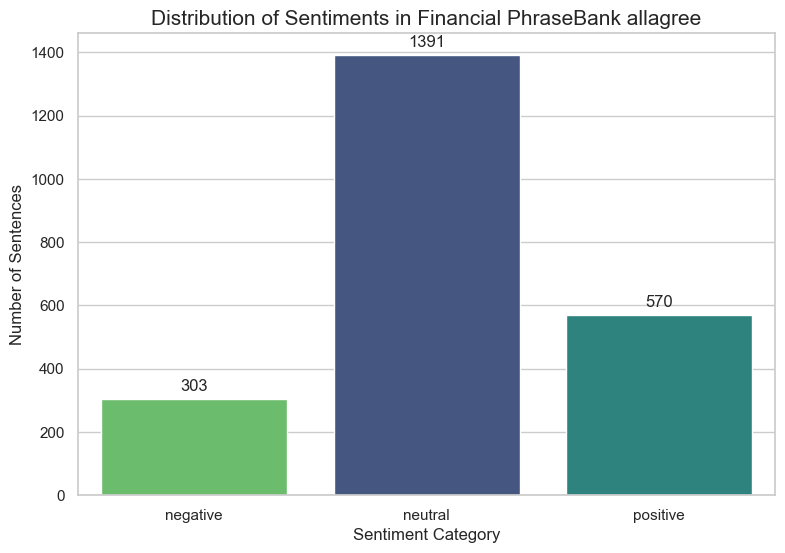

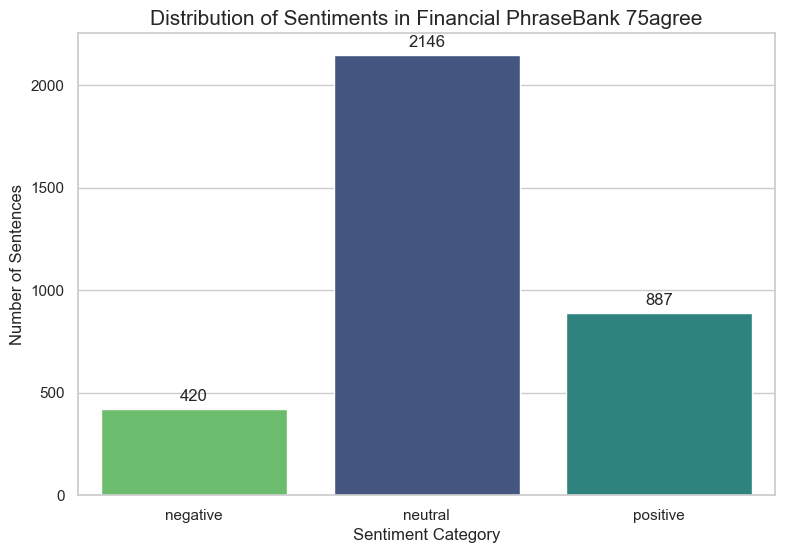

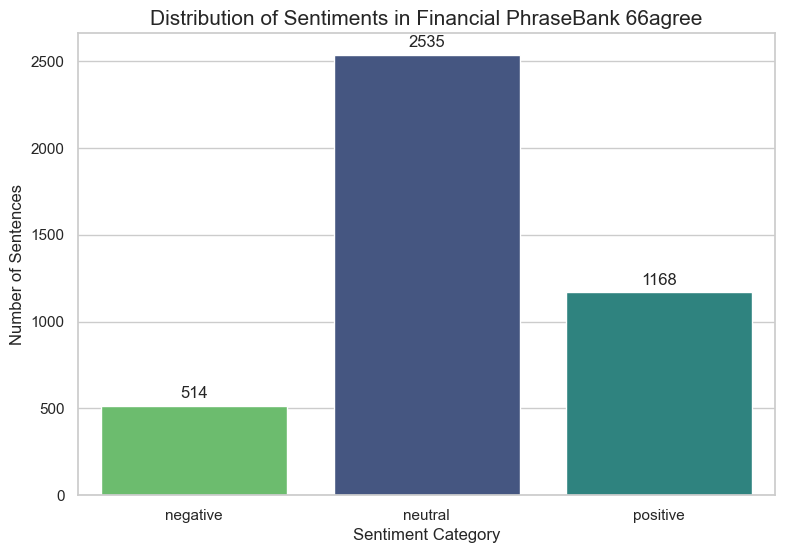

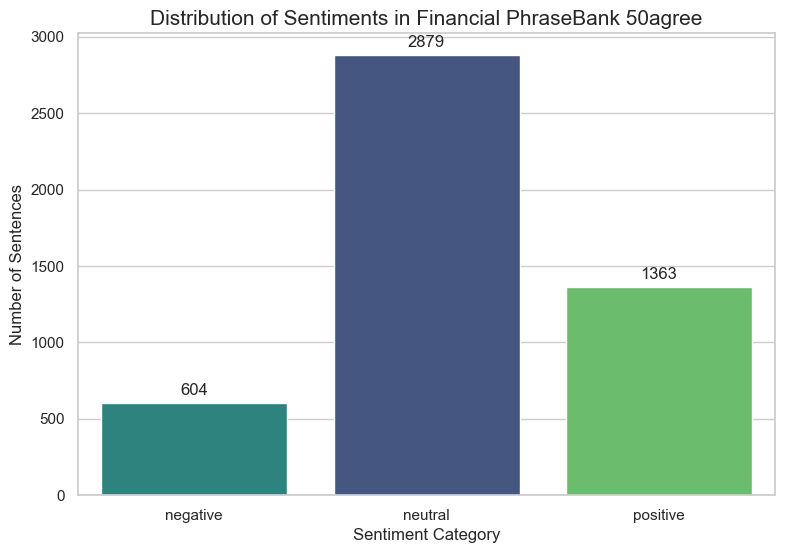

In [125]:
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df_allagree, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank allagree', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df_75agree, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank 75agree', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df_66agree, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank 66agree', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df_50agree, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank 50agree', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

In [126]:
stats = {
    'all': df_allagree['label'].value_counts(normalize=True).to_dict(),
    '75':  df_75agree['label'].value_counts(normalize=True).to_dict(),
    '66':  df_66agree['label'].value_counts(normalize=True).to_dict(),
    '50':  df_50agree['label'].value_counts(normalize=True).to_dict()
}
print(stats)

{'all': {'neutral': 0.6143992932862191, 'positive': 0.25176678445229683, 'negative': 0.1338339222614841}, '75': {'neutral': 0.6214885606718795, 'positive': 0.2568780770344628, 'negative': 0.12163336229365769}, '66': {'neutral': 0.6011382499407162, 'positive': 0.2769741522409296, 'negative': 0.12188759781835427}, '50': {'neutral': 0.594098225340487, 'positive': 0.28126289723483283, 'negative': 0.12463887742468015}}


In [127]:
df_final = df_50agree.copy()

def assign_custom_weight(row):
    sentence = row['sentence']
    
    if sentence in set_all:
        return 1.3
    
    elif sentence in set_75:
        return 1.1
    
    elif sentence in set_66:
        return 1
    
    else:
        return 0.9


# Apply to the whole row
df_final['weight'] = df_final.apply(assign_custom_weight, axis=1)

<font color=3C99D size=5>
Conclusion: </font>

Since the set of 50 agree is the most general one we will train on that and based on how sure they are, we gave them a weight and then in the loss function, we included them with that weight.

In [128]:
df = df_final

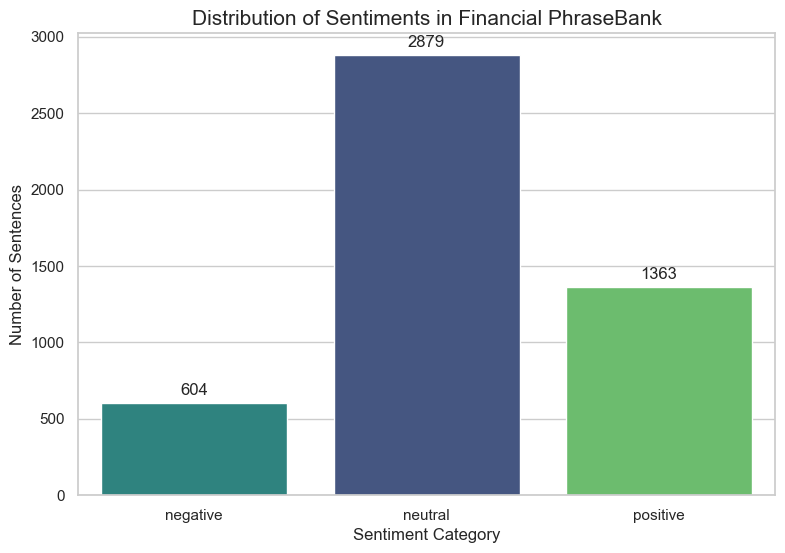

In [129]:
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

In [130]:
label_encoder = LabelEncoder() #turning labels to numbers
df['label_idx'] = label_encoder.fit_transform(df['label'])

class_names = label_encoder.classes_
print(f"Mapping: {dict(zip(range(len(class_names)), class_names))}")

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_idx']
)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}
Train size: 3876, Validation size: 970


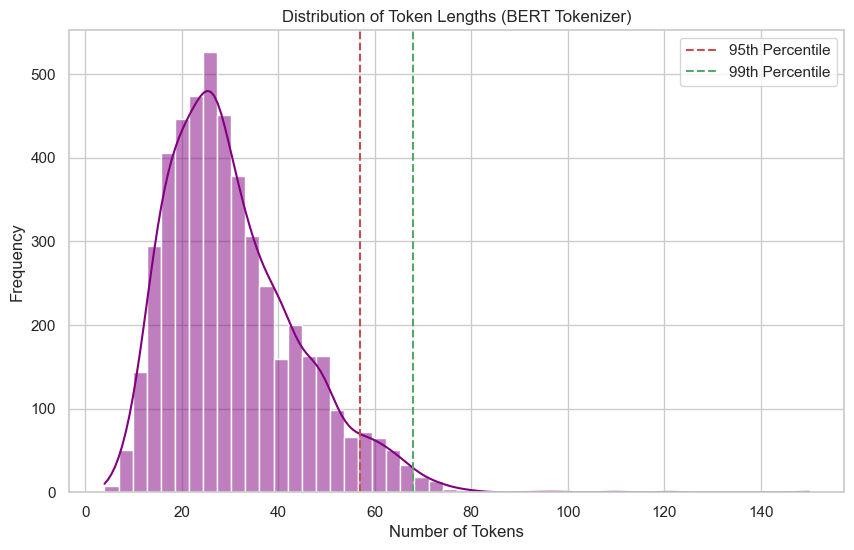

95% Percentile: 57.0
99% Percentile: 68.0
Max Length: 150


In [131]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df['token_lengths'] = [len(tokenizer.encode(s, add_special_tokens=True)) for s in df['sentence']]

plt.figure(figsize=(10, 6))
sns.histplot(df['token_lengths'], bins=50, kde=True, color='purple')
plt.title('Distribution of Token Lengths (BERT Tokenizer)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

plt.axvline(x=df['token_lengths'].quantile(0.95), color='r', linestyle='--', label='95th Percentile')
plt.axvline(x=df['token_lengths'].quantile(0.99), color='g', linestyle='--', label='99th Percentile')
plt.legend()
plt.show()

print(f"95% Percentile: {df['token_lengths'].quantile(0.95)}")
print(f"99% Percentile: {df['token_lengths'].quantile(0.99)}")
print(f"Max Length: {df['token_lengths'].max()}")

<font color=3C99D size=5>
Conclusion: </font>

Since only less than one percent of the sentences have more than 68 tokens, choosing 80 tokens as the max length is a good number



In [132]:
class FinancialDataset(Dataset):
    def __init__(self, sentences, labels, weights, tokenizer, max_len=80):
        self.sentences = sentences.values
        self.labels = labels.values
        self.weights = weights.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = str(self.sentences[item])
        label = self.labels[item]
        weight = self.weights[item]

        encoding = self.tokenizer(
            sentence,
            add_special_tokens=True,  #Added [CLS], [SEP]
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'weights': torch.tensor(weight, dtype=torch.float)
        }

In [133]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_dataset = FinancialDataset(train_df['sentence'], train_df['label_idx'], train_df['weight'], tokenizer)
val_dataset = FinancialDataset(val_df['sentence'], val_df['label_idx'], val_df['weight'], tokenizer)

BATCH_SIZE = 16 #todo change to see the different results

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

sample_batch = next(iter(train_loader))
print(f"Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"Attention Mask shape: {sample_batch['attention_mask'].shape}")

Input IDs shape: torch.Size([16, 80])
Attention Mask shape: torch.Size([16, 80])


# PART TWO

---

In [ ]:
dropout_val = 0.3

In [134]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        Q = self.W_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, V)

        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        return self.W_o(output)

In [ ]:
class TransformerBlock(nn.Module):#Encoder only, as we need the whole thing for sentiment analysis and we don't need the masked multihead attention in decoder.
    def __init__(self, d_model, num_heads, ff_hidden_dim, dropout): #ff_hidden_dim can be increased in the case of underfitting
    # and decreased in the case of overfitting #todo ff_hidden_dim hyperparameter
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, d_model)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.attention.forward(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))

        return x

In [ ]:
class FinancialTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, ff_hidden_dim, max_len, num_classes=3):
        super(FinancialTransformer, self).__init__()

        #these are learnable embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)

        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, ff_hidden_dim, dropout_val)
            for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(dropout_val)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attention_mask):
        batch_size, seq_len = input_ids.shape

        #creating a list of numbers for each position and expanding it to every sentence and putting it on the same device as input_ids so we won't get an error.
        positions = torch.arange(0, seq_len).expand(batch_size, seq_len).to(input_ids.device)

        x = self.token_embedding(input_ids) + self.position_embedding(positions)
        x = self.dropout(x)

        mask = attention_mask.unsqueeze(1).unsqueeze(2)

        #Passing through all the encoder layers.
        for layer in self.layers:
            x = layer(x, mask)


        #The classifier expects a 2D tensor. So we only use the value for [CLS] which is the first token of every sentence as a summary for all the tokens of the sentence.
        cls_output = x[:, 0, :]

        #We are just using a linear mapping on the outputs and not a softmax. Later when we use nn.CrossEntropyLoss the softmax will be applied.
        #That is computationaly better as we won't have to deal with big or small numbers with some tricks.
        return self.fc(cls_output)

SyntaxError: non-default argument follows default argument (2739124465.py, line 2)

In [ ]:
VOCAB_SIZE = tokenizer.vocab_size
D_MODEL = 256     #Hyperparameter  -> must be divisible by NUM_HEADS
NUM_HEADS = 4      #Hyperparameter
NUM_LAYERS = 4     #Hyperparameter
FF_HIDDEN_DIM = 1024  #Hyperparameter
MAX_LEN = 80          #Don't put it less than 68 and make it divisible by 8
NUM_CLASSES = 3

model = FinancialTransformer(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    ff_hidden_dim=FF_HIDDEN_DIM,
    max_len=MAX_LEN,
    num_classes=NUM_CLASSES
)

print(model)

FinancialTransformer(
  (token_embedding): Embedding(30522, 256)
  (position_embedding): Embedding(80, 256)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=True)
        (W_k): Linear(in_features=256, out_features=256, bias=True)
        (W_v): Linear(in_features=256, out_features=256, bias=True)
        (W_o): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=256, out_features=2048, bias=True)
        (1): ReLU()
        (2): Linear(in_features=2048, out_features=256, bias=True)
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)


# PART THREE

---

In [138]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Device set to: Apple MPS (GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Device set to: NVIDIA CUDA (GPU)")
else:
    device = torch.device("cpu")
    print("Device set to: CPU")

if colab:
      path = '/content/drive/MyDrive/data/checkpoint.pth'
      huge_path = '/content/drive/MyDrive/data/checkpoint_huge.pth' #20 epochs tested for finding the best
else:
      path = 'checkpoint.pth'
      huge_path = 'checkpoint_huge.pth'

model.to(device)


Device set to: Apple MPS (GPU)


FinancialTransformer(
  (token_embedding): Embedding(30522, 256)
  (position_embedding): Embedding(80, 256)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=True)
        (W_k): Linear(in_features=256, out_features=256, bias=True)
        (W_v): Linear(in_features=256, out_features=256, bias=True)
        (W_o): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=256, out_features=2048, bias=True)
        (1): ReLU()
        (2): Linear(in_features=2048, out_features=256, bias=True)
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [139]:
labels = df_final['label'].values
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# criterion = nn.CrossEntropyLoss(reduction='none') #By setting reduction to none we are telling it not to give us the mean of the losses of the batches
#We want the loss for each one so we can multiply it by its corresponding weight.

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)

In [140]:
# This will reduce the learning rate by half if the validation loss doesn't improve for 2 epochs.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=2, 
    verbose=True
)

/opt/homebrew/Caskroom/miniconda/base/envs/py10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


<font color=DC143C size=6>
Warning </font>

Only set the train boolean in the cell below to True if you want to train and else set it to False. If you want to train it and use 20 epochs, set huge_epoch and train to True.

In [141]:
train = True
huge_epoch = False

In [142]:
def evaluate_model(model, data_loader):
    model.to(device)
    model.eval() # Sets layers like Dropout to off

    val_loss, val_correct = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad(): # Stops memory use for gradients
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.mean().item()
            _, preds = torch.max(outputs, dim=1)
            val_correct += torch.sum(preds == labels)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = val_loss / len(data_loader)
    avg_acc = val_correct / len(data_loader.dataset)

    report = classification_report(all_labels, all_preds, target_names=['Neg', 'Neu', 'Pos'], zero_division=0)
    print(report)

    return avg_loss, avg_acc


In [143]:
def train_model(model, train_loader, val_loader, epochs=5):
    model.to(device)

    train_history = {'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            weights = batch['weights'].to(device)

            #Each batch should be handled seperatly so we reset it for each of them.
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)

            losses = criterion(outputs, labels)
            loss = torch.mean(losses * weights)

            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            total_correct += (preds == labels).sum().item() #We don't include the weights here as it makes it harder to explain

        avg_loss = total_loss / len(train_loader)
        avg_acc = total_correct / len(train_loader.dataset)

        train_history['loss'].append(avg_loss)
        train_history['acc'].append(avg_acc)

        v_loss, v_acc = evaluate_model(model, val_loader)
        train_history['val_loss'].append(v_loss)
        train_history['val_acc'].append(v_acc)
        if v_acc > best_val_acc:
            best_val_acc = v_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step(v_loss)

        print(f'Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Acc: {avg_acc:.4f} | Val Loss: {v_loss:.4f} | Val Acc: {v_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return train_history



In [144]:
epochs = 20
if train and huge_epoch:
  history = train_model(model, train_loader, val_loader, epochs)

  checkpoint = {
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'history': history,
      'epoch': epochs
  }
  torch.save(checkpoint, huge_path)

In [145]:
# if not huge_epoch:
#   if os.path.exists(huge_path):
#       checkpoint = torch.load(huge_path, map_location=device)

#       model.load_state_dict(checkpoint['model_state_dict'])

#       optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#       history = checkpoint['history']

#       model.to(device)
#       print(f"Successfully loaded checkpoint from epoch {checkpoint['epoch']}")
#   else:
#       print("No checkpoint found. You need to train the model first.")
#       history = train_model(model, train_loader, epochs)

#       checkpoint = {
#           'model_state_dict': model.state_dict(),
#           'optimizer_state_dict': optimizer.state_dict(),
#           'history': history,
#           'epoch': epochs
#       }
#       torch.save(checkpoint, huge_path)

In [146]:
def plot_results(history):
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, [h.cpu() if torch.is_tensor(h) else h for h in history['loss']], 'b-', label='Train Loss')
    plt.plot(epochs, [h.cpu() if torch.is_tensor(h) else h for h in history['val_loss']], 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, [h.cpu() if torch.is_tensor(h) else h for h in history['acc']], 'b-', label='Train Acc')
    plt.plot(epochs, [h.cpu() if torch.is_tensor(h) else h for h in history['val_acc']], 'r-', label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [147]:
# plot_results(history)

<font color=3C99D size=5>
Conclusion: </font>

After ten epochs, the model starts to overfit and therefore, we won't train on more than 10 epochs.



In [148]:
epochs = 15 #Hyperparameter
if train:
  history = train_model(model, train_loader, val_loader, epochs)

  checkpoint = {
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'history': history,
      'epoch': epochs
  }
  torch.save(checkpoint, path)
else:
  if os.path.exists(path):
      checkpoint = torch.load(path, map_location=device)

      model.load_state_dict(checkpoint['model_state_dict'])

      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

      history = checkpoint['history']

      model.to(device)
      print(f"Successfully loaded checkpoint from epoch {checkpoint['epoch']}")
  else:
      print("No checkpoint found. You need to train the model first.")
      history = train_model(model, train_loader, epochs)

      checkpoint = {
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'history': history,
          'epoch': epochs
      }
      torch.save(checkpoint, path)

              precision    recall  f1-score   support

         Neg       0.00      0.00      0.00       121
         Neu       0.77      0.25      0.38       576
         Pos       0.31      0.89      0.46       273

    accuracy                           0.40       970
   macro avg       0.36      0.38      0.28       970
weighted avg       0.54      0.40      0.35       970

Epoch 1/15 | Loss: 1.3670 | Acc: 0.3470 | Val Loss: 1.1254 | Val Acc: 0.4000
              precision    recall  f1-score   support

         Neg       0.17      0.77      0.27       121
         Neu       0.77      0.54      0.64       576
         Pos       0.00      0.00      0.00       273

    accuracy                           0.42       970
   macro avg       0.31      0.44      0.30       970
weighted avg       0.48      0.42      0.41       970

Epoch 2/15 | Loss: 1.3025 | Acc: 0.4182 | Val Loss: 1.1093 | Val Acc: 0.4186
              precision    recall  f1-score   support

         Neg       0.47      

5e-5 learning rate            
            
            
              precision    recall  f1-score   support

         Neg       0.33      0.44      0.38       121
         Neu       0.76      0.55      0.64       576
         Pos       0.37      0.53      0.44       273

    accuracy                           0.53       970
   macro avg       0.49      0.51      0.48       970
weighted avg       0.59      0.53      0.55       970

Epoch 1/15 | Loss: 1.3305 | Acc: 0.3648 | Val Loss: 1.0911 | Val Acc: 0.5309
              precision    recall  f1-score   support

         Neg       0.25      0.58      0.34       121
         Neu       0.76      0.47      0.58       576
         Pos       0.35      0.42      0.39       273

    accuracy                           0.47       970
   macro avg       0.45      0.49      0.44       970
weighted avg       0.58      0.47      0.50       970

Epoch 2/15 | Loss: 1.2737 | Acc: 0.4680 | Val Loss: 1.0726 | Val Acc: 0.4711
              precision    recall  f1-score   support

         Neg       0.22      0.74      0.34       121
         Neu       0.77      0.65      0.71       576
         Pos       0.42      0.12      0.18       273

    accuracy                           0.51       970
   macro avg       0.47      0.50      0.41       970
weighted avg       0.60      0.51      0.51       970

Epoch 3/15 | Loss: 1.2355 | Acc: 0.5108 | Val Loss: 1.0599 | Val Acc: 0.5124
              precision    recall  f1-score   support

         Neg       0.30      0.60      0.39       121
         Neu       0.79      0.59      0.68       576
         Pos       0.42      0.46      0.44       273

    accuracy                           0.55       970
   macro avg       0.50      0.55      0.50       970
weighted avg       0.63      0.55      0.57       970

Epoch 4/15 | Loss: 1.2087 | Acc: 0.5317 | Val Loss: 1.0368 | Val Acc: 0.5536
              precision    recall  f1-score   support

         Neg       0.28      0.68      0.40       121
         Neu       0.78      0.65      0.71       576
         Pos       0.50      0.36      0.42       273

    accuracy                           0.57       970
   macro avg       0.52      0.56      0.51       970
weighted avg       0.64      0.57      0.59       970

Epoch 5/15 | Loss: 1.1828 | Acc: 0.5627 | Val Loss: 1.0251 | Val Acc: 0.5742
              precision    recall  f1-score   support

         Neg       0.54      0.36      0.43       121
         Neu       0.78      0.78      0.78       576
         Pos       0.53      0.60      0.56       273

    accuracy                           0.68       970
   macro avg       0.61      0.58      0.59       970
weighted avg       0.68      0.68      0.67       970

Epoch 6/15 | Loss: 1.1365 | Acc: 0.5998 | Val Loss: 1.0378 | Val Acc: 0.6763
              precision    recall  f1-score   support

         Neg       0.26      0.75      0.38       121
         Neu       0.80      0.66      0.73       576
         Pos       0.61      0.31      0.41       273

    accuracy                           0.58       970
   macro avg       0.56      0.58      0.51       970
weighted avg       0.68      0.58      0.60       970

Epoch 7/15 | Loss: 1.0899 | Acc: 0.6138 | Val Loss: 1.0111 | Val Acc: 0.5763
              precision    recall  f1-score   support

         Neg       0.47      0.50      0.49       121
         Neu       0.80      0.68      0.74       576
         Pos       0.49      0.63      0.55       273

    accuracy                           0.65       970
   macro avg       0.59      0.61      0.59       970
weighted avg       0.67      0.65      0.65       970

Epoch 8/15 | Loss: 1.0584 | Acc: 0.6324 | Val Loss: 0.9867 | Val Acc: 0.6454
              precision    recall  f1-score   support

         Neg       0.48      0.53      0.50       121
         Neu       0.80      0.63      0.70       576
         Pos       0.47      0.66      0.55       273

    accuracy                           0.63       970
   macro avg       0.58      0.61      0.59       970
weighted avg       0.67      0.63      0.64       970

Epoch 9/15 | Loss: 1.0177 | Acc: 0.6612 | Val Loss: 0.9959 | Val Acc: 0.6258
              precision    recall  f1-score   support

         Neg       0.35      0.68      0.46       121
         Neu       0.80      0.72      0.76       576
         Pos       0.57      0.46      0.51       273

    accuracy                           0.64       970
   macro avg       0.57      0.62      0.58       970
weighted avg       0.68      0.64      0.65       970

Epoch 10/15 | Loss: 0.9964 | Acc: 0.6778 | Val Loss: 0.9936 | Val Acc: 0.6392
              precision    recall  f1-score   support

         Neg       0.31      0.72      0.43       121
         Neu       0.82      0.63      0.71       576
         Pos       0.54      0.48      0.51       273

    accuracy                           0.60       970
   macro avg       0.56      0.61      0.55       970
weighted avg       0.68      0.60      0.62       970

Epoch 11/15 | Loss: 0.9661 | Acc: 0.7012 | Val Loss: 1.0294 | Val Acc: 0.6000
              precision    recall  f1-score   support

         Neg       0.38      0.60      0.47       121
         Neu       0.81      0.65      0.72       576
         Pos       0.49      0.57      0.53       273

    accuracy                           0.62       970
   macro avg       0.56      0.61      0.57       970
weighted avg       0.67      0.62      0.64       970

Epoch 12/15 | Loss: 0.9217 | Acc: 0.7276 | Val Loss: 1.0274 | Val Acc: 0.6216
              precision    recall  f1-score   support

         Neg       0.38      0.60      0.47       121
         Neu       0.80      0.64      0.71       576
         Pos       0.49      0.57      0.53       273

    accuracy                           0.62       970
   macro avg       0.56      0.60      0.57       970
weighted avg       0.66      0.62      0.63       970

Epoch 13/15 | Loss: 0.9230 | Acc: 0.7363 | Val Loss: 1.0398 | Val Acc: 0.6155
              precision    recall  f1-score   support

         Neg       0.34      0.69      0.45       121
         Neu       0.82      0.68      0.74       576
         Pos       0.56      0.51      0.53       273

    accuracy                           0.63       970
   macro avg       0.57      0.62      0.57       970
weighted avg       0.68      0.63      0.64       970

Epoch 14/15 | Loss: 0.8953 | Acc: 0.7436 | Val Loss: 1.0526 | Val Acc: 0.6289
              precision    recall  f1-score   support

         Neg       0.45      0.53      0.48       121
         Neu       0.80      0.63      0.71       576
         Pos       0.48      0.65      0.55       273

    accuracy                           0.63       970
   macro avg       0.58      0.60      0.58       970
weighted avg       0.67      0.63      0.64       970

Epoch 15/15 | Loss: 0.8693 | Acc: 0.7572 | Val Loss: 1.0648 | Val Acc: 0.6258

              precision    recall  f1-score   support

         Neg       0.20      0.66      0.31       121
         Neu       0.71      0.71      0.71       576
         Pos       0.00      0.00      0.00       273

    accuracy                           0.50       970
   macro avg       0.31      0.46      0.34       970
weighted avg       0.45      0.50      0.46       970

Epoch 1/15 | Loss: 1.3506 | Acc: 0.3532 | Val Loss: 1.1071 | Val Acc: 0.5031
              precision    recall  f1-score   support

         Neg       0.19      0.84      0.31       121
         Neu       0.77      0.48      0.59       576
         Pos       0.38      0.10      0.16       273

    accuracy                           0.42       970
   macro avg       0.45      0.47      0.35       970
weighted avg       0.59      0.42      0.43       970

Epoch 2/15 | Loss: 1.2588 | Acc: 0.4938 | Val Loss: 1.0986 | Val Acc: 0.4175
              precision    recall  f1-score   support

         Neg       0.33      0.37      0.35       121
         Neu       0.80      0.48      0.60       576
         Pos       0.40      0.70      0.51       273

    accuracy                           0.53       970
   macro avg       0.51      0.52      0.49       970
weighted avg       0.63      0.53      0.54       970

Epoch 3/15 | Loss: 1.2097 | Acc: 0.5320 | Val Loss: 1.0477 | Val Acc: 0.5309
              precision    recall  f1-score   support

         Neg       0.41      0.56      0.47       121
         Neu       0.78      0.61      0.68       576
         Pos       0.43      0.56      0.49       273

    accuracy                           0.59       970
   macro avg       0.54      0.58      0.55       970
weighted avg       0.64      0.59      0.60       970

Epoch 4/15 | Loss: 1.1291 | Acc: 0.5906 | Val Loss: 1.0389 | Val Acc: 0.5887
              precision    recall  f1-score   support

         Neg       0.50      0.46      0.48       121
         Neu       0.76      0.73      0.75       576
         Pos       0.50      0.56      0.53       273

    accuracy                           0.65       970
   macro avg       0.59      0.59      0.59       970
weighted avg       0.66      0.65      0.65       970

Epoch 5/15 | Loss: 1.0794 | Acc: 0.6365 | Val Loss: 1.0434 | Val Acc: 0.6505
              precision    recall  f1-score   support

         Neg       0.48      0.56      0.52       121
         Neu       0.77      0.75      0.76       576
         Pos       0.54      0.52      0.53       273

    accuracy                           0.66       970
   macro avg       0.60      0.61      0.60       970
weighted avg       0.67      0.66      0.66       970

Epoch 6/15 | Loss: 1.0097 | Acc: 0.6747 | Val Loss: 1.0394 | Val Acc: 0.6629
              precision    recall  f1-score   support

         Neg       0.39      0.63      0.48       121
         Neu       0.77      0.66      0.71       576
         Pos       0.51      0.52      0.52       273

    accuracy                           0.62       970
   macro avg       0.56      0.60      0.57       970
weighted avg       0.65      0.62      0.63       970

Epoch 7/15 | Loss: 0.9759 | Acc: 0.6940 | Val Loss: 1.0210 | Val Acc: 0.6196
              precision    recall  f1-score   support

         Neg       0.56      0.48      0.52       121
         Neu       0.73      0.85      0.78       576
         Pos       0.63      0.46      0.53       273

    accuracy                           0.69       970
   macro avg       0.64      0.59      0.61       970
weighted avg       0.68      0.69      0.68       970

Epoch 8/15 | Loss: 0.9349 | Acc: 0.7178 | Val Loss: 1.1194 | Val Acc: 0.6907
              precision    recall  f1-score   support

         Neg       0.48      0.61      0.54       121
         Neu       0.78      0.73      0.75       576
         Pos       0.57      0.58      0.57       273

    accuracy                           0.67       970
   macro avg       0.61      0.64      0.62       970
weighted avg       0.68      0.67      0.68       970

Epoch 9/15 | Loss: 0.9106 | Acc: 0.7273 | Val Loss: 1.0337 | Val Acc: 0.6711
              precision    recall  f1-score   support

         Neg       0.30      0.71      0.42       121
         Neu       0.79      0.63      0.70       576
         Pos       0.59      0.48      0.53       273

    accuracy                           0.60       970
   macro avg       0.56      0.61      0.55       970
weighted avg       0.67      0.60      0.62       970

Epoch 10/15 | Loss: 0.8630 | Acc: 0.7572 | Val Loss: 1.1018 | Val Acc: 0.5979
              precision    recall  f1-score   support

         Neg       0.46      0.64      0.53       121
         Neu       0.77      0.75      0.76       576
         Pos       0.60      0.52      0.56       273

    accuracy                           0.67       970
   macro avg       0.61      0.64      0.62       970
weighted avg       0.68      0.67      0.68       970

Epoch 11/15 | Loss: 0.8408 | Acc: 0.7743 | Val Loss: 1.0713 | Val Acc: 0.6732
              precision    recall  f1-score   support

         Neg       0.37      0.64      0.47       121
         Neu       0.78      0.66      0.71       576
         Pos       0.56      0.56      0.56       273

    accuracy                           0.63       970
   macro avg       0.57      0.62      0.58       970
weighted avg       0.67      0.63      0.64       970

Epoch 12/15 | Loss: 0.8030 | Acc: 0.8024 | Val Loss: 1.0884 | Val Acc: 0.6289
              precision    recall  f1-score   support

         Neg       0.49      0.59      0.53       121
         Neu       0.78      0.69      0.73       576
         Pos       0.54      0.61      0.57       273

    accuracy                           0.66       970
   macro avg       0.60      0.63      0.61       970
weighted avg       0.67      0.66      0.66       970

Epoch 13/15 | Loss: 0.7849 | Acc: 0.8055 | Val Loss: 1.0911 | Val Acc: 0.6567
              precision    recall  f1-score   support

         Neg       0.44      0.60      0.51       121
         Neu       0.78      0.68      0.72       576
         Pos       0.54      0.59      0.56       273

    accuracy                           0.64       970
   macro avg       0.58      0.62      0.60       970
weighted avg       0.67      0.64      0.65       970

Epoch 14/15 | Loss: 0.7636 | Acc: 0.8238 | Val Loss: 1.1014 | Val Acc: 0.6443
              precision    recall  f1-score   support

         Neg       0.49      0.54      0.51       121
         Neu       0.77      0.74      0.76       576
         Pos       0.57      0.58      0.57       273

    accuracy                           0.67       970
   macro avg       0.61      0.62      0.61       970
weighted avg       0.68      0.67      0.67       970

Epoch 15/15 | Loss: 0.7580 | Acc: 0.8246 | Val Loss: 1.1106 | Val Acc: 0.6711

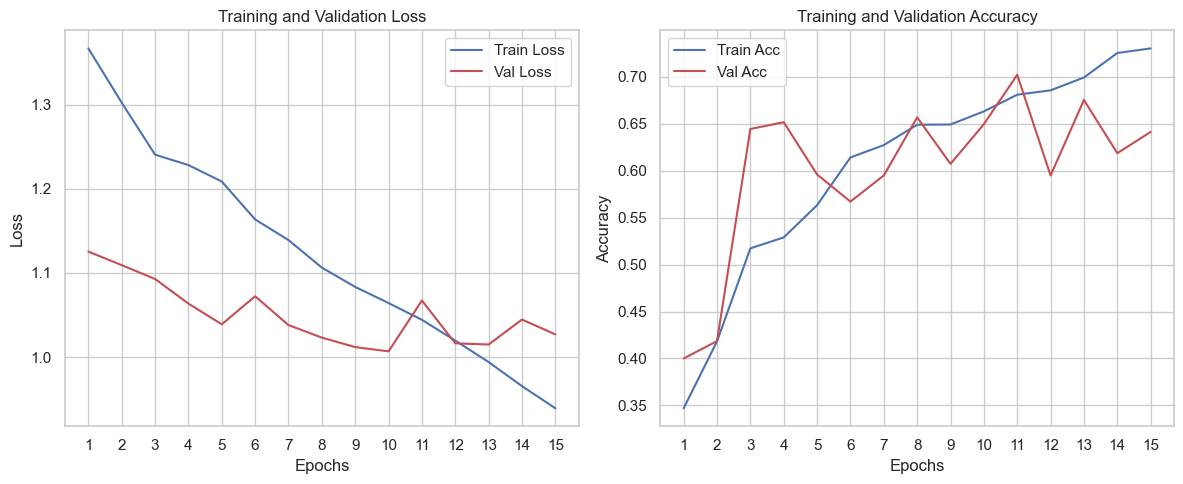

In [149]:
plot_results(history)

# PART FOUR

---